# Домашнее задание

- Скачайте текст войны и мир (ссылка на [github](https://github.com/netology-code/ds3-spring-2018/tree/master/7.%20Time_series/7.4/war_and_peace) и [гугл диск](https://drive.google.com/drive/u/2/folders/1aM7cNI6Qs7AyeYpQ8lNg7vLsHzIl0JbU)). Очистите его, оставив только русские буквы и символы пробела. Постройте матрицу переходных вероятностей. Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р; Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов
- [Выберите ряд](https://datamarket.com/data/list/?q=cat:fpg%20provider:tsdl) и оцените его через HMM. Попробуйте "построить" (через среднее каждой компоненты) наивный прогноз ряда.

In [183]:
import numpy as np
import pandas as pd
import seaborn as sns
import re

from hmmlearn.hmm import GaussianHMM
from sklearn.utils import check_random_state
from scipy.stats import boxcox
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [3]:
with open('war_and_peace/tom_1.txt', 'r') as f:
    tom_1 = f.read().lower()

In [4]:
with open('war_and_peace/tom_2.txt', 'r') as f:
    tom_2 = f.read().lower()

In [5]:
with open('war_and_peace/tom_3.txt', 'r') as f:
    tom_3 = f.read().lower()

In [6]:
with open('war_and_peace/tom_4.txt', 'r') as f:
    tom_4 = f.read().lower()

In [12]:
text = tom_1 + tom_2 + tom_3 + tom_4

In [13]:
text = re.sub('[^а-яё ]', '', text)

In [25]:
RUSSIAN = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(RUSSIAN)}

### Матрица переходных вероятностей

In [26]:
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))

In [27]:
for left, right in zip(text[:-1], text[1:]):
    probabilities[POS[left], POS[right]] += 1

In [28]:
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [29]:
df = pd.DataFrame(probabilities, index = (c for c in RUSSIAN), columns = (c for c in RUSSIAN))

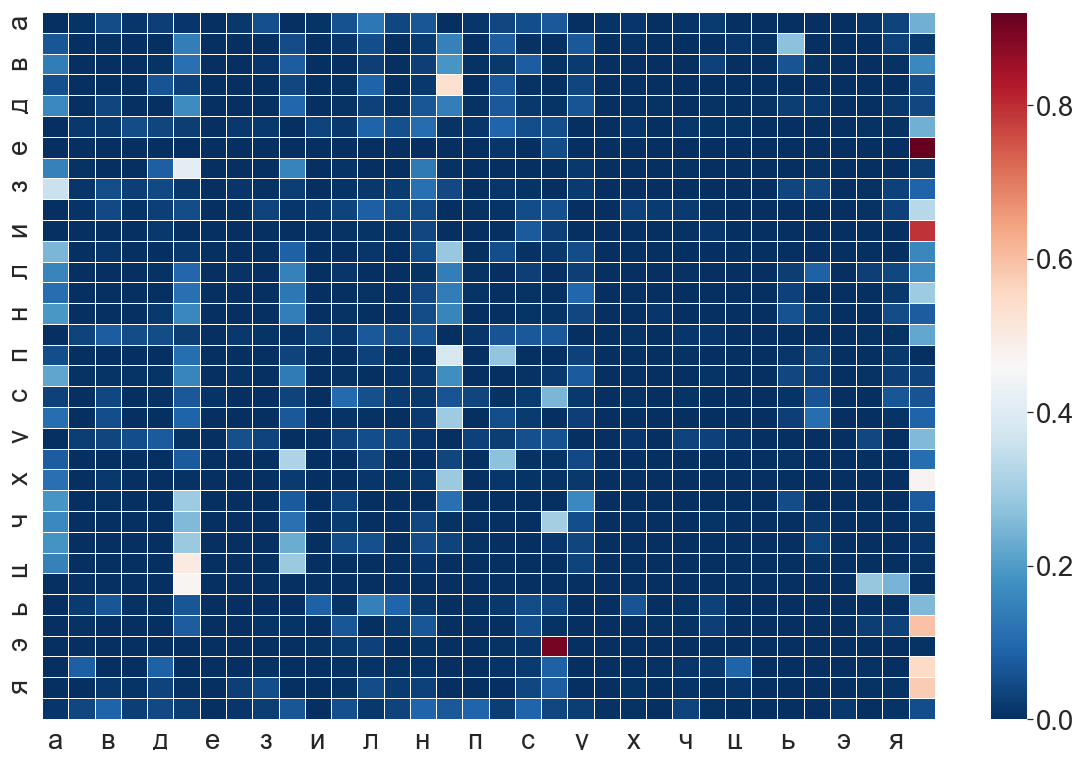

In [77]:
plt.figure(figsize=(20, 13))
sns.set(font_scale=2.5)
sns.heatmap(df, linewidths=0.01, cmap='RdBu_r')
plt.show()

### Вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р

In [88]:
start = POS['п']
end = POS['р']
prior = 1. / len(RUSSIAN)
sum_proba = 0

for c_1 in RUSSIAN[:-1]:
    for c_2 in RUSSIAN[:-1]:
        proba = prior * probabilities[start, POS[c_1]] * probabilities[POS[c_1], POS[c_2]] * probabilities[POS[c_2], end]
        sum_proba += proba
        if proba > 0.00001:
            print(''.join(['п', c_1, c_2, 'р']), proba)

print('\nВероятность = ', sum_proba)

пегр 1.1112317321777153e-05
пепр 1.2112841989055931e-05
побр 2.9433951560885752e-05
повр 1.4354422427861556e-05
погр 3.84767361012238e-05
подр 3.817691323612121e-05
поер 2.580608653130366e-05
попр 4.141720191311109e-05
потр 4.228590463090975e-05
прар 7.43645140131875e-05
прер 0.00011985973476310438
прор 9.147367042682817e-05
прур 1.5378847130707658e-05

Вероятность =  0.0008111325031082472


### Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы "Б" и имеющее длину 8-мь символов

In [118]:
s = []
start = 'б'
s.append(start)

length = 8
for i in range(length - 1):
    index = POS[s[i]]
    next_char = np.random.choice(list(RUSSIAN), p=probabilities[index])
    s.append(next_char)

print(''.join(s))

будазаро


### HMM

In [192]:
series = pd.read_csv("../1/Series/mean-monthly-air-temperature-deg.csv")['Deg']

In [193]:
values = series.values.reshape(-1,1)

In [194]:
model = GaussianHMM(n_components=14,
                        covariance_type="diag",
                        n_iter=1000)
model.fit(values)
states = model.predict(values)

In [195]:
means = np.zeros_like(values)
for i in range(model.n_components):
    means[states == i] = model.means_[i]

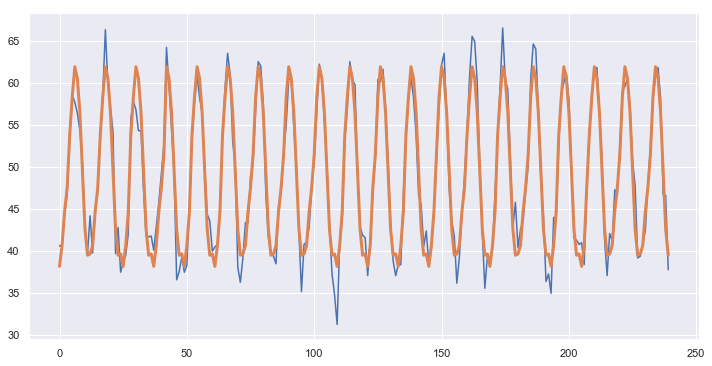

In [196]:
plt.figure(figsize=(12, 6))
sns.set(font_scale=1)
plt.plot(values)
plt.plot(means, linewidth=3)
plt.show()

Как видно, в целом модель примерно описала основные характеристики ряда, но качество оставляет желать лучшего. Смоделированный ряд, в отличие от реального, не меняет амплитуды и не "захватывает" вершины. 

### Попробуйте "построить" (через среднее каждой компоненты) наивный прогноз ряда.

In [197]:
transmat_cdf = np.cumsum(model.transmat_, axis=1)
random_state = check_random_state(model.random_state)

In [198]:
new_states = states.copy()
for i in range(10):
    new_states = np.append(new_states, (transmat_cdf[new_states[-1]] > random_state.rand()).argmax())

In [199]:
new_means = np.zeros_like(new_states)
for i in range(model.n_components):
    new_means[new_states == i] = model.means_[i]

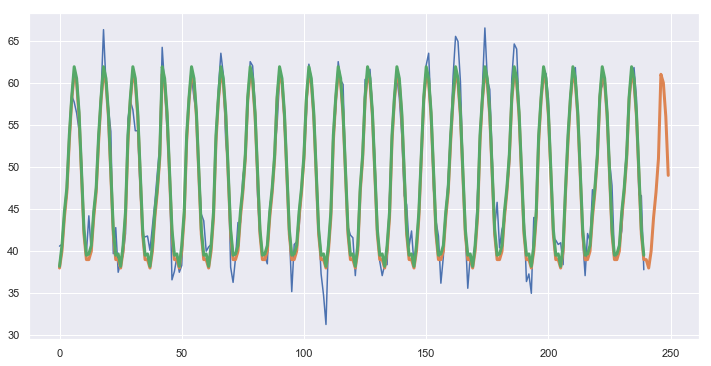

In [200]:
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(new_means, linewidth=3)
plt.plot(means, linewidth=3)
plt.show()

Оранжевым на графике обозначен прогноз на 10 значений вперед. 